### Import basic libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import sklearn
from sklearn.metrics import confusion_matrix
from IPython.display import Audio
from sklearn import preprocessing

import os
import re


### Import data

In [3]:
train_list= os.listdir("./train/train")


In [4]:
test_list = os.listdir("./test/test")

### Extract information from file names

##### Extract train's emotions and genders

In [5]:
regex = re.compile(r'\w')
train_gender=[]
train_emotion=[]
for name in train_list:
    train_gender.append(regex.findall(name)[4])
    train_emotion.append(regex.findall(name)[5])

##### Extract test's genders

In [6]:
test_gender=[]
test_emotion=[]
for name in test_list:
    test_gender.append(regex.findall(name)[4])

### Extract test and train's file path for each sample

In [7]:
train_path=[]
for name in train_list:
    train_path.append("./train/train/"+name)

test_path=[]
for name in test_list:
    test_path.append("./test/test/"+name)

___________

### Create the train data frame

In [8]:
emotion_df=pd.DataFrame(train_emotion,columns=['emotion'])
gender_df=pd.DataFrame(train_gender,columns=['gender'])
path_df=pd.DataFrame(train_path,columns=['path'])
train_df=pd.concat([emotion_df,gender_df,path_df],axis=1)

In [9]:
le = preprocessing.LabelEncoder()
a=le.fit_transform(train_df.emotion)
a=pd.DataFrame(a,columns=['label'])
train_df=pd.concat((train_df,a),axis=1)

In [10]:
train_df.head()

emotion gender                                              path  label
0       A      M  C:/Users/Saberi/Downloads/train/train/0000MA.wav      0
1       A      M  C:/Users/Saberi/Downloads/train/train/0003MA.wav      0
2       N      M  C:/Users/Saberi/Downloads/train/train/0004MN.wav      2
3       S      F  C:/Users/Saberi/Downloads/train/train/0005FS.wav      3
4       A      M  C:/Users/Saberi/Downloads/train/train/0006MA.wav      0

In [11]:
train_df.shape

(1994, 4)

### Create the test data frame

In [12]:
gender_df=pd.DataFrame(test_gender,columns=['gender'])
path_df=pd.DataFrame(test_path,columns=['path'])
real=pd.read_csv('C:/Users/Saberi/Downloads/result.csv')['label']
test_df=pd.concat([gender_df,path_df,real],axis=1)

In [13]:
test_df.head()

gender                                           path label
0      F  C:/Users/Saberi/Downloads/test/test/2705F.wav     N
1      M  C:/Users/Saberi/Downloads/test/test/2707M.wav     H
2      F  C:/Users/Saberi/Downloads/test/test/2708F.wav     N
3      M  C:/Users/Saberi/Downloads/test/test/2710M.wav     A
4      M  C:/Users/Saberi/Downloads/test/test/2711M.wav     A

In [14]:
test_df.shape

(227, 3)

____________

#### Visualize number of observations in each emotion for training set

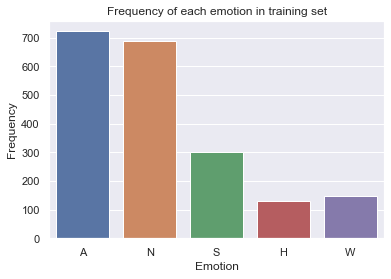

In [15]:
sns.set_theme(style="darkgrid")
sns.countplot(x='emotion',data=train_df)
plt.ylabel('Frequency')
plt.xlabel('Emotion')
plt.title('Frequency of each emotion in training set')
plt.show()

#### Visualize the Distribution of gender for training set

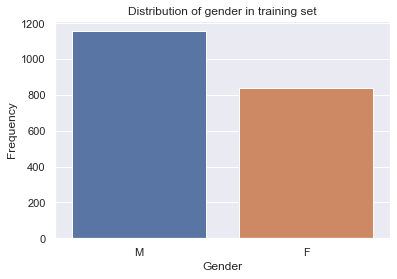

In [16]:
sns.set_theme(style="darkgrid")
sns.countplot(x='gender',data=train_df)
plt.ylabel('Frequency')
plt.xlabel('Gender')
plt.title('Distribution of gender in training set')
plt.show()

#### Visualize number of observations in each emotion for test set

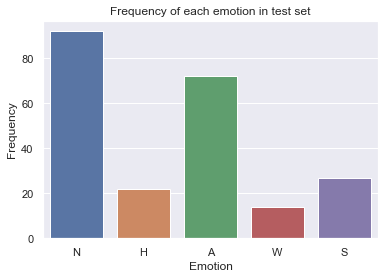

In [17]:
sns.set_theme(style="darkgrid")
sns.countplot(x='label',data=test_df)
plt.ylabel('Frequency')
plt.xlabel('Emotion')
plt.title('Frequency of each emotion in test set')
plt.show()

#### Visualize the Distribution of gender for training set

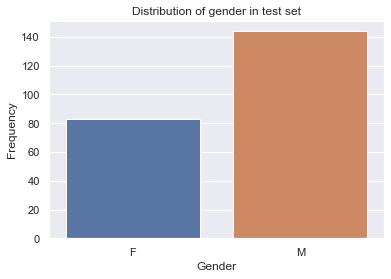

In [18]:
sns.set_theme(style="darkgrid")
sns.countplot(x='gender',data=test_df)
plt.ylabel('Frequency')
plt.xlabel('Gender')
plt.title('Distribution of gender in test set')
plt.show()

**As you know, A represents Anger, H represents Happiness , N represents Neutral , S represents Sadness and W represents Wonder.**

As you can see, classes are imbalanced and happiness class has the least number of samples.

In [19]:
###counting the frequency of each label in the training dataset
w=pd.DataFrame(np.bincount(train_df['label']))
w.T

0    1    2    3    4
0  723  130  690  302  149

In [20]:
### defining a function who will alocate larger weights to smaller classes and vice versa.
def create_class_weight(w):
    class_weights={}
    for i in range(5):

        weight=(1/np.squeeze(w.iloc[i])) * (sum(w[0]))/len(w)
        class_weights[i]=weight
    return class_weights


#we will use it later on the .fit function in training
class_weights=create_class_weight(w)

In [21]:
class_weights

{0: 0.5515905947441218,
 1: 3.0676923076923077,
 2: 0.5779710144927537,
 3: 1.3205298013245033,
 4: 2.676510067114094}

_____________

### Visualize loadness of each emotion

In [22]:
def plot_load(a):
    data,sr=librosa.load(train_df[train_df['emotion']==a]['path'].iloc[0])
    librosa.display.waveplot(data, sr=sr)
    plt.title(f'loadness of emotion: {a}')
    plt.show()

Waveplot of being **Angry**

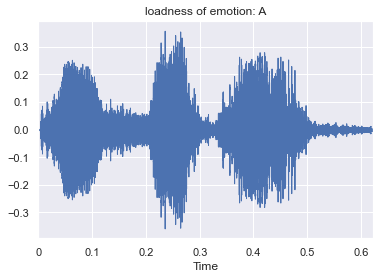

In [23]:
plot_load("A")
Audio(train_df[train_df['emotion']=="A"]['path'].iloc[0])

Waveplot of being **Wondered**

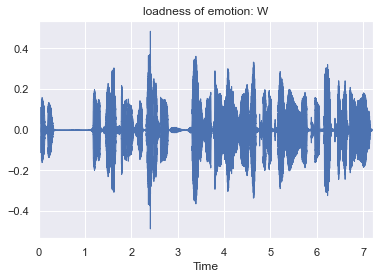

In [24]:
plot_load("W")
Audio(train_df[train_df['emotion']=="W"]['path'].iloc[0])

Waveplot of being **Sad**

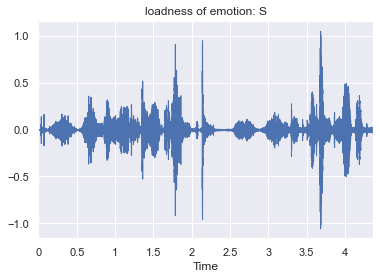

In [25]:
plot_load("S")
Audio(train_df[train_df['emotion']=="S"]['path'].iloc[0])

Waveplot of being **Neutered**

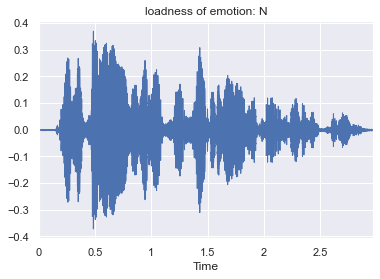

In [26]:
plot_load("N")
Audio(train_df[train_df['emotion']=="N"]['path'].iloc[0])

Waveplot of being **Happy**

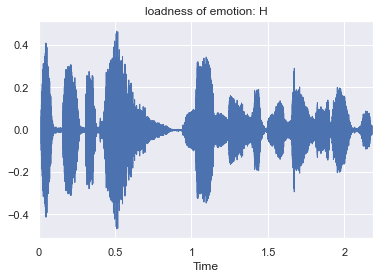

In [27]:
plot_load("H")
Audio(train_df[train_df['emotion']=="H"]['path'].iloc[0])

___________

___________

### Feature Extraction

Before building out feature extractor function to convert vocal time series to features, We intend to show what will each feature demonstrate.

1) MFCC feature

In [28]:
def plot_mfcc(path):
    x, sr= librosa.load(path)
    mfccs=librosa.feature.mfcc(y=x,sr=sr,n_mfcc=56)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax,cmap='coolwarm')
    fig.colorbar(img, ax=ax)

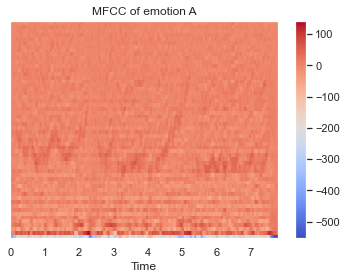

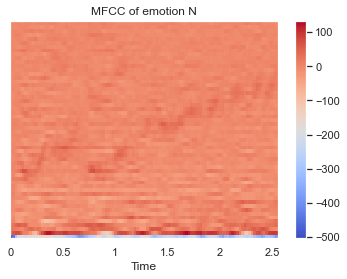

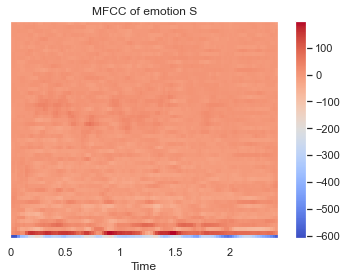

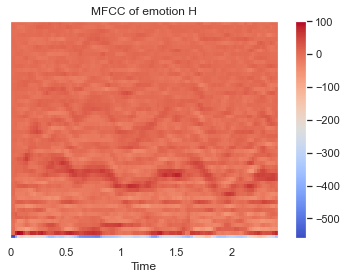

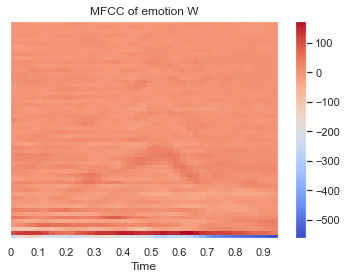

In [29]:
for i in range(5):
    emo=train_df.emotion.unique()[i]
    plot_mfcc(train_df[train_df.emotion==emo]['path'].iloc[1])
    plt.title(f'MFCC of emotion {emo}')

2) Chroma

In [30]:
def plot_chroma(path):
    x, sr= librosa.load(path)
    chrom=librosa.feature.chroma_stft(x, sr=sr)
    fig, ax = plt.subplots()
    librosa.display.specshow(chrom, x_axis='time', y_axis='chroma', cmap='coolwarm')

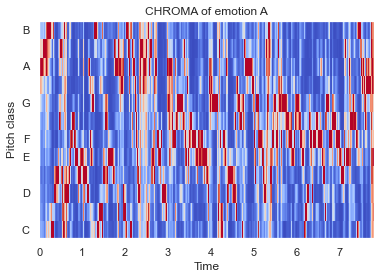

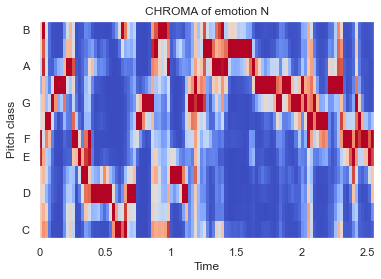

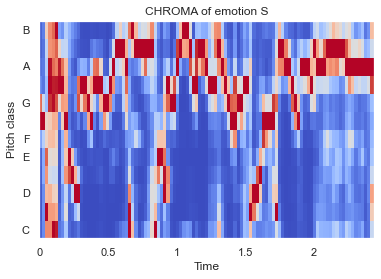

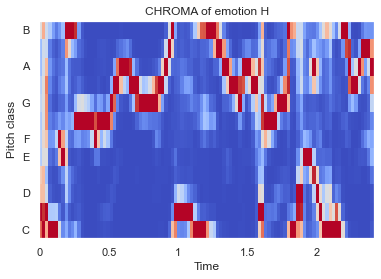

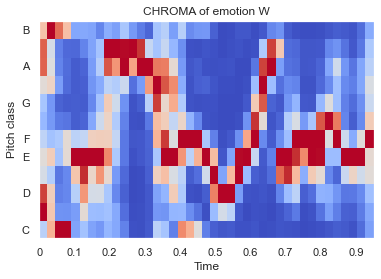

In [31]:
for i in range(5):
    emo=train_df.emotion.unique()[i]
    plot_chroma(train_df[train_df.emotion==emo]['path'].iloc[1])
    plt.title(f'CHROMA of emotion {emo}')

3) Spectral Contrast

In [32]:
def plot_sc(path):
    x, sr= librosa.load(path)
    sc=librosa.feature.spectral_contrast(x, sr=sr)
    fig, ax = plt.subplots()
    librosa.display.specshow(sc, x_axis='time', y_axis='chroma', cmap='coolwarm')

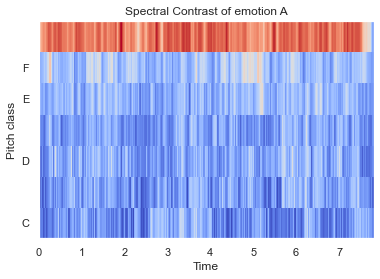

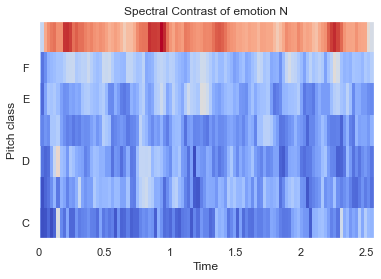

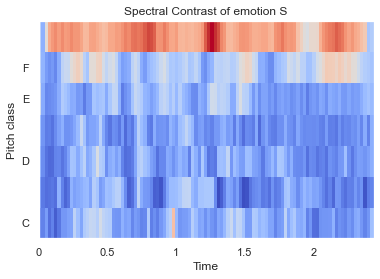

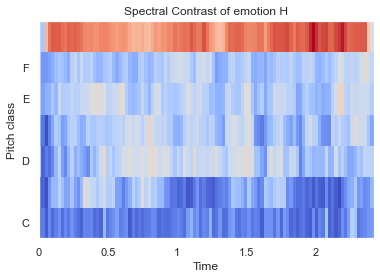

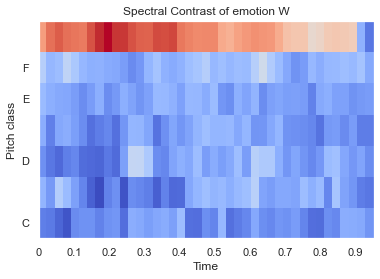

In [33]:
for i in range(5):
    emo=train_df.emotion.unique()[i]
    plot_sc(train_df[train_df.emotion==emo]['path'].iloc[1])
    plt.title(f'Spectral Contrast of emotion {emo}')

_______

In [34]:
def f_extractor(path,mfcc,chroma,sc):
    x, sr= librosa.load(path,sr=None)
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=x,sr=sr,n_mfcc=64).T,axis=0)
        result=np.hstack((result,mfccs))
    if chroma:
        chrom=librosa.feature.chroma_stft(x,sr)
        chroma=np.max(chrom.T,axis=0)-np.min(chrom.T,axis=0)
        result=np.hstack((result,chroma))
    if sc:
        sc=np.mean(librosa.feature.spectral_contrast(x,sr).T,axis=0)
        result=np.hstack((result,sc))
    return result


In [35]:
x, y = [], []
for path,emotion in zip(train_df.path,train_df.emotion):
    feature=f_extractor(path,True,False,True)
    x.append(feature)
    y.append(emotion)

In [36]:
x2, y2 = [], []
for path,emotion in zip(train_df.path,train_df.emotion):
    feature=f_extractor(path,True,True,False)
    x2.append(feature)
    y2.append(emotion)

In [37]:
len(x), len(y)

(1994, 1994)

In [38]:
len(x2), len(y2)

(1994, 1994)

In [39]:
x[0].shape

(71,)

In [40]:
x2[0].shape

(76,)

In [41]:
x=sklearn.preprocessing.scale(x,axis=1)
x2=sklearn.preprocessing.scale(x2,axis=1)

In [42]:
features = []
features2 = []
for i in range(len(x)):
    ftr=x[i]
    ftr2=x2[i]
    feature = ftr.reshape(x[0].shape[0],1)
    feature2 = ftr2.reshape(x2[0].shape[0],1)
    features.append(feature)
    features2.append(feature2)
    
features = np.asarray(features)
features2 = np.asarray(features2)

In [43]:
y=le.fit_transform(y)
y2=le.fit_transform(y2)

In [44]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(y,5)
y2=to_categorical(y2,5)

In [45]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets vs Epochs')
    axs[1].plot(df['val_accuracy'])
    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets vs Epochs')
    plt.show()

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM

def fitmodel(name):
    model = Sequential()
    model.add(LSTM(128,input_shape=name.shape[1:],activation='tanh', recurrent_activation='sigmoid',
               return_sequences=True))
    #model.add(Dropout(0.1))
    model.add(LSTM(64,input_shape=features.shape[1:],activation='tanh', recurrent_activation='sigmoid',
               return_sequences=False))
   # model.add(Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    
    return model

In [47]:
model=fitmodel(features)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 71, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 122,821
Trainable params: 122,821
Non-trainable params: 0
__________________________________________________

In [48]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(features,y ,epochs=60,batch_size = 128 ,verbose=1,validation_split=0.2)

Epoch 1/60
13/13 [==============================] - 1s 63ms/step - loss: 1.5430 - accuracy: 0.3618 - val_loss: 1.4631 - val_accuracy: 0.3383
Epoch 2/60
13/13 [==============================] - 0s 20ms/step - loss: 1.4198 - accuracy: 0.3636 - val_loss: 1.3808 - val_accuracy: 0.3383
Epoch 3/60
13/13 [==============================] - 0s 21ms/step - loss: 1.4016 - accuracy: 0.3687 - val_loss: 1.3746 - val_accuracy: 0.3383
Epoch 4/60
13/13 [==============================] - 0s 21ms/step - loss: 1.4018 - accuracy: 0.3730 - val_loss: 1.3785 - val_accuracy: 0.3383
Epoch 5/60
13/13 [==============================] - 0s 21ms/step - loss: 1.3990 - accuracy: 0.3636 - val_loss: 1.3653 - val_accuracy: 0.3383
Epoch 6/60
13/13 [==============================] - 0s 21ms/step - loss: 1.3981 - accuracy: 0.3687 - val_loss: 1.3634 - val_accuracy: 0.3383
Epoch 7/60
13/13 [==============================] - 0s 21ms/step - loss: 1.3983 - accuracy: 0.3762 - val_loss: 1.3809 - val_accuracy: 0.3383
Epoch 8/60
13

Epoch 59/60
13/13 [==============================] - 0s 21ms/step - loss: 1.0037 - accuracy: 0.6426 - val_loss: 0.9767 - val_accuracy: 0.6316
Epoch 60/60
13/13 [==============================] - 0s 21ms/step - loss: 0.9811 - accuracy: 0.6445 - val_loss: 1.0003 - val_accuracy: 0.6341


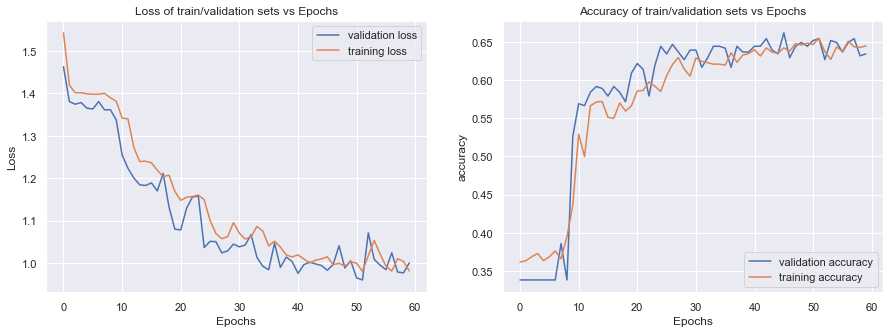

In [50]:
plot_model(history)

In [51]:
model1=fitmodel(features)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history1 = model.fit(features,y ,epochs=60,batch_size = 128 ,verbose=1,validation_split=0.2,
                   class_weight=class_weights )

Epoch 1/60
13/13 [==============================] - 0s 23ms/step - loss: 1.3932 - accuracy: 0.6188 - val_loss: 1.2145 - val_accuracy: 0.5815
Epoch 2/60
13/13 [==============================] - 0s 22ms/step - loss: 1.3150 - accuracy: 0.5787 - val_loss: 1.2617 - val_accuracy: 0.5464
Epoch 3/60
13/13 [==============================] - 0s 21ms/step - loss: 1.3256 - accuracy: 0.5624 - val_loss: 1.2910 - val_accuracy: 0.5138
Epoch 4/60
13/13 [==============================] - 0s 22ms/step - loss: 1.3430 - accuracy: 0.5448 - val_loss: 1.2451 - val_accuracy: 0.5539
Epoch 5/60
13/13 [==============================] - 0s 21ms/step - loss: 1.3322 - accuracy: 0.5749 - val_loss: 1.2288 - val_accuracy: 0.5664
Epoch 6/60
13/13 [==============================] - 0s 22ms/step - loss: 1.3270 - accuracy: 0.5900 - val_loss: 1.2253 - val_accuracy: 0.5689
Epoch 7/60
13/13 [==============================] - 0s 22ms/step - loss: 1.3167 - accuracy: 0.5850 - val_loss: 1.2611 - val_accuracy: 0.5514
Epoch 8/60
13

Epoch 59/60
13/13 [==============================] - 0s 21ms/step - loss: 1.2481 - accuracy: 0.5981 - val_loss: 1.1962 - val_accuracy: 0.5288
Epoch 60/60
13/13 [==============================] - 0s 21ms/step - loss: 1.2367 - accuracy: 0.5611 - val_loss: 1.1825 - val_accuracy: 0.5464


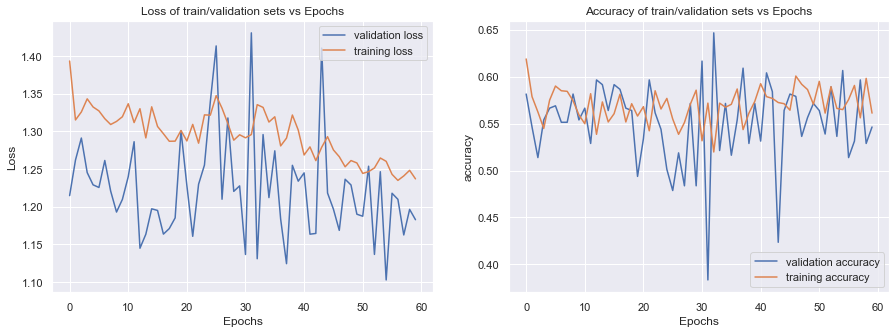

In [53]:
plot_model(history1)

______________

In [54]:
model2=fitmodel(features2)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 76, 128)           66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 85        
Total params: 122,821
Trainable params: 122,821
Non-trainable params: 0
________________________________________________

In [55]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
history2 = model2.fit(features2,y2 ,epochs=60,batch_size = 128 ,verbose=1,validation_split=0.2)

Epoch 1/60
13/13 [==============================] - 1s 74ms/step - loss: 1.5483 - accuracy: 0.3467 - val_loss: 1.4554 - val_accuracy: 0.3383
Epoch 2/60
13/13 [==============================] - 0s 22ms/step - loss: 1.4318 - accuracy: 0.3687 - val_loss: 1.3934 - val_accuracy: 0.3383
Epoch 3/60
13/13 [==============================] - 0s 21ms/step - loss: 1.4080 - accuracy: 0.3755 - val_loss: 1.3640 - val_accuracy: 0.3383
Epoch 4/60
13/13 [==============================] - 0s 20ms/step - loss: 1.4006 - accuracy: 0.3687 - val_loss: 1.3709 - val_accuracy: 0.3383
Epoch 5/60
13/13 [==============================] - 0s 19ms/step - loss: 1.4039 - accuracy: 0.3693 - val_loss: 1.3689 - val_accuracy: 0.3383
Epoch 6/60
13/13 [==============================] - 0s 20ms/step - loss: 1.3955 - accuracy: 0.3687 - val_loss: 1.3665 - val_accuracy: 0.3383
Epoch 7/60
13/13 [==============================] - 0s 20ms/step - loss: 1.3897 - accuracy: 0.4219 - val_loss: 1.3212 - val_accuracy: 0.5965
Epoch 8/60
13

Epoch 59/60
13/13 [==============================] - 0s 19ms/step - loss: 0.9895 - accuracy: 0.6408 - val_loss: 0.9794 - val_accuracy: 0.6491
Epoch 60/60
13/13 [==============================] - 0s 20ms/step - loss: 0.9870 - accuracy: 0.6458 - val_loss: 1.0001 - val_accuracy: 0.6366


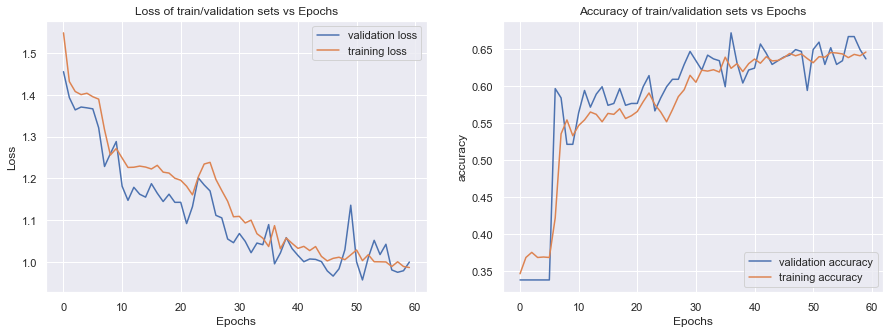

In [57]:
plot_model(history2)

In [60]:
model3=fitmodel(features2)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 76, 128)           66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 85        
Total params: 122,821
Trainable params: 122,821
Non-trainable params: 0
________________________________________________

In [61]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model.fit(features2,y2 ,epochs=60,batch_size = 128 ,verbose=1,validation_split=0.2,
                   class_weight=class_weights )

Epoch 1/60
13/13 [==============================] - 0s 24ms/step - loss: 1.1776 - accuracy: 0.5787 - val_loss: 1.1862 - val_accuracy: 0.5138
Epoch 2/60
13/13 [==============================] - 0s 22ms/step - loss: 1.1698 - accuracy: 0.5661 - val_loss: 1.1883 - val_accuracy: 0.5313
Epoch 3/60
13/13 [==============================] - 0s 21ms/step - loss: 1.1914 - accuracy: 0.5837 - val_loss: 1.1293 - val_accuracy: 0.5514
Epoch 4/60
13/13 [==============================] - 0s 21ms/step - loss: 1.2345 - accuracy: 0.5467 - val_loss: 1.2059 - val_accuracy: 0.5614
Epoch 5/60
13/13 [==============================] - 0s 21ms/step - loss: 1.1961 - accuracy: 0.5793 - val_loss: 1.1599 - val_accuracy: 0.5890
Epoch 6/60
13/13 [==============================] - 0s 22ms/step - loss: 1.1838 - accuracy: 0.5705 - val_loss: 1.1422 - val_accuracy: 0.5764
Epoch 7/60
13/13 [==============================] - 0s 21ms/step - loss: 1.1702 - accuracy: 0.6069 - val_loss: 1.1306 - val_accuracy: 0.5739
Epoch 8/60
13

Epoch 59/60
13/13 [==============================] - 0s 20ms/step - loss: 1.1111 - accuracy: 0.5975 - val_loss: 1.1507 - val_accuracy: 0.5589
Epoch 60/60
13/13 [==============================] - 0s 20ms/step - loss: 1.0926 - accuracy: 0.6270 - val_loss: 1.2591 - val_accuracy: 0.4912


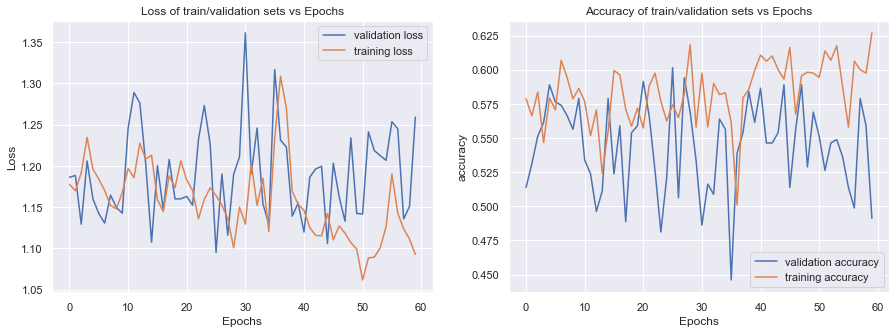

In [62]:
plot_model(history3)

According to above results, we decided to go with the first model which has MFCC and spectrul contrast features amd no weighted classes.

### Evaluation process

From the test set we should extract the exact feutures that we've extracted from the training set.

In [64]:
x_test = []
for path in test_df.path:
    fft=f_extractor(path,True,False,True)
    x_test.append(fft)
x_test=sklearn.preprocessing.scale(x_test,axis=1)

In [68]:
test_ftr = []
for i in range(len(x_test)):
    ftr=x_test[i]
    feature = ftr.reshape(x_test[i].shape[0],1)
    test_ftr.append(feature)
    
test_ftr = np.asarray(test_ftr)

____________

#### Evaluation of Model1(without weight class / mfcc+sc feature)

In [71]:
pred_test1 = model.predict(test_ftr,batch_size=32,verbose=1)

8/8 [==============================] - 0s 4ms/step


Convert softmax vectors to numeric labels

In [72]:
pred1=np.argmax(pred_test1,axis=1)

_____________

So now we know that 0: Angry , 1: Happy , 2: Neutral , 3: Sad and 4: Wondered

In [73]:
pred1=list(pred1)
for i in range(len(pred1)):
    if pred1[i]==0:
        pred1[i]='A'
    elif pred1[i]==1:
        pred1[i]='H'
    elif pred1[i]==2:
        pred1[i]='N'
    elif pred1[i]==3:
        pred1[i]='S'
    else:
        pred1[i]='W'

In [74]:
real=list(test_df.label)
acc = pd.DataFrame(columns=['Predicted', 'Real'])
acc['Predicted'] = pred1
acc['Real'] = real

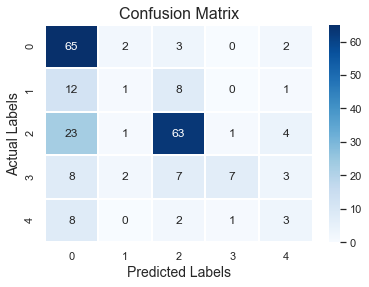

In [76]:
cm = pd.DataFrame(confusion_matrix(real, pred1))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [77]:
df=pd.concat([test_df,acc],axis=1)
FEMALE=df[df.gender=="F"]
MALE=df[df.gender=='M']

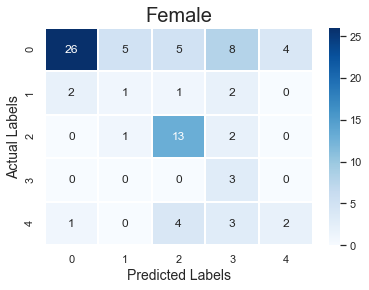

In [78]:
cm = pd.DataFrame(confusion_matrix(FEMALE.Predicted, FEMALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Female', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

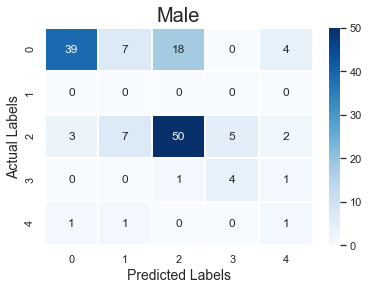

In [79]:
cm = pd.DataFrame(confusion_matrix(MALE.Predicted, MALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Male', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

____________

#### Evaluation of Model2(without weight class / mfcc+chroma feature)

In [99]:
pred_test2 = model2.predict(test_ftr,batch_size=32,verbose=1)

8/8 [==============================] - 0s 4ms/step


Convert softmax vectors to numeric labels

In [100]:
pred2=np.argmax(pred_test2,axis=1)

____________

So now we know that 0: Angry , 1: Happy , 2: Neutral , 3: Sad and 4: Wondered

In [101]:
pred2=list(pred2)
for i in range(len(pred2)):
    if pred2[i]==0:
        pred2[i]='A'
    elif pred2[i]==1:
        pred2[i]='H'
    elif pred2[i]==2:
        pred2[i]='N'
    elif pred2[i]==3:
        pred2[i]='S'
    else:
        pred2[i]='W'

In [102]:
real=list(test_df.label)
acc = pd.DataFrame(columns=['Predicted', 'Real'])
acc['Predicted'] = pred2
acc['Real'] = real

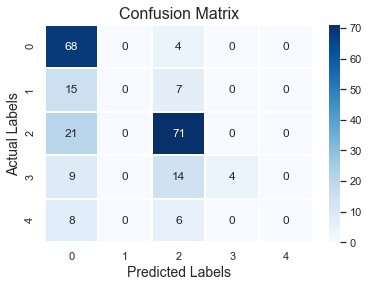

In [103]:
cm = pd.DataFrame(confusion_matrix(real, pred2))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [105]:
df=pd.concat([test_df,acc],axis=1)
FEMALE=df[df.gender=="F"]
MALE=df[df.gender=='M']

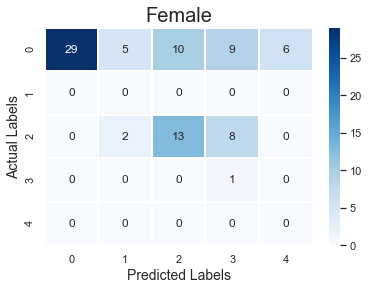

In [106]:
cm = pd.DataFrame(confusion_matrix(FEMALE.Predicted, FEMALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Female', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

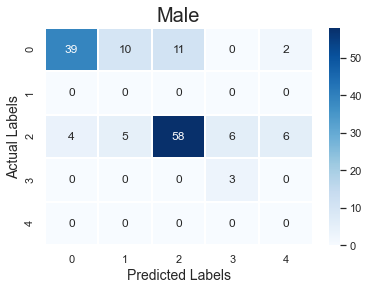

In [107]:
cm = pd.DataFrame(confusion_matrix(MALE.Predicted, MALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Male', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

_______

Now that we've decide to go with mfcc/sc features, we want to manipulate networks structure to see whether we can achieve better accuracy or not.

In [108]:
def fitmodel(name):
    model = Sequential()
    model.add(LSTM(256,input_shape=name.shape[1:],activation='tanh', recurrent_activation='sigmoid',
               return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128,input_shape=features.shape[1:],activation='tanh', recurrent_activation='sigmoid',
               return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    
    return model

In [109]:
testmodel=fitmodel(features)
testmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 71, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 71, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)               

In [110]:
testmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
testhistory = testmodel.fit(features,y ,epochs=60,batch_size = 128 ,verbose=1,validation_split=0.2)

Epoch 1/60
13/13 [==============================] - 1s 85ms/step - loss: 1.5261 - accuracy: 0.3511 - val_loss: 1.4472 - val_accuracy: 0.3860
Epoch 2/60
13/13 [==============================] - 1s 44ms/step - loss: 1.4282 - accuracy: 0.3480 - val_loss: 1.3940 - val_accuracy: 0.3383
Epoch 3/60
13/13 [==============================] - 1s 43ms/step - loss: 1.4127 - accuracy: 0.3455 - val_loss: 1.3696 - val_accuracy: 0.3383
Epoch 4/60
13/13 [==============================] - 1s 44ms/step - loss: 1.4050 - accuracy: 0.3555 - val_loss: 1.3699 - val_accuracy: 0.3383
Epoch 5/60
13/13 [==============================] - 1s 44ms/step - loss: 1.4006 - accuracy: 0.3674 - val_loss: 1.3688 - val_accuracy: 0.3383
Epoch 6/60
13/13 [==============================] - 1s 43ms/step - loss: 1.3953 - accuracy: 0.3705 - val_loss: 1.3578 - val_accuracy: 0.3383
Epoch 7/60
13/13 [==============================] - 1s 43ms/step - loss: 1.3948 - accuracy: 0.3781 - val_loss: 1.3549 - val_accuracy: 0.4712
Epoch 8/60
13

Epoch 59/60
13/13 [==============================] - 1s 44ms/step - loss: 0.9862 - accuracy: 0.6433 - val_loss: 0.9558 - val_accuracy: 0.6617
Epoch 60/60
13/13 [==============================] - 1s 43ms/step - loss: 0.9661 - accuracy: 0.6508 - val_loss: 0.9936 - val_accuracy: 0.6541


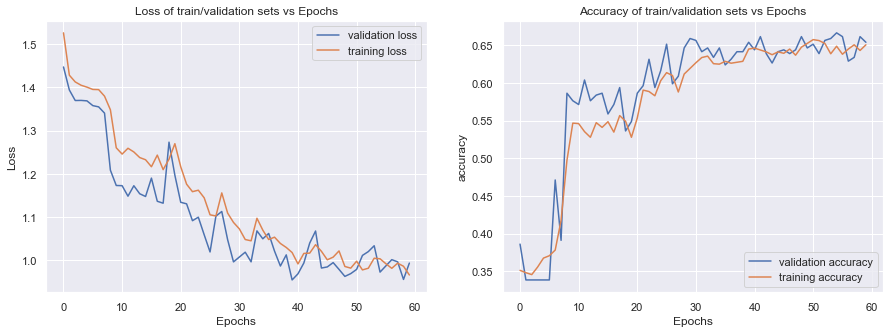

In [111]:
plot_model(testhistory)

In [112]:
prdt = testmodel.predict(test_ftr,batch_size=32,verbose=1)
prdt=np.argmax(prdt,axis=1)

8/8 [==============================] - 0s 7ms/step


In [113]:
prdt=list(prdt)
for i in range(len(prdt)):
    if prdt[i]==0:
        prdt[i]='A'
    elif prdt[i]==1:
        prdt[i]='H'
    elif prdt[i]==2:
        prdt[i]='N'
    elif prdt[i]==3:
        prdt[i]='S'
    else:
        prdt[i]='W'

In [122]:
real=list(test_df.label)
acc = pd.DataFrame(columns=['Predicted', 'Real'])
acc['Predicted'] = prdt
acc['Real'] = real

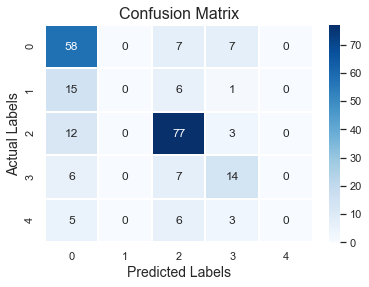

In [123]:
cm = pd.DataFrame(confusion_matrix(real, prdt))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [124]:
df=pd.concat([test_df,acc],axis=1)
FEMALE=df[df.gender=="F"]
MALE=df[df.gender=='M']

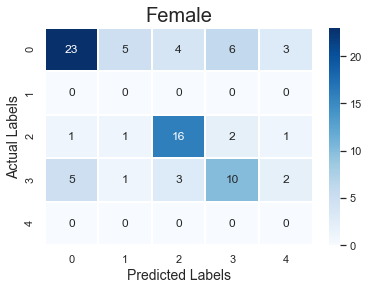

In [125]:
cm = pd.DataFrame(confusion_matrix(FEMALE.Predicted, FEMALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Female', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

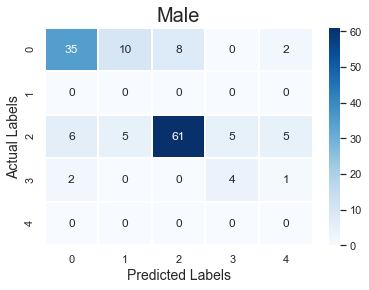

In [126]:
cm = pd.DataFrame(confusion_matrix(MALE.Predicted, MALE.Real))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True)
plt.title('Male', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [127]:
testmodel.save_weights("lstm.best_model_weights.h5")
testmodel.save("lstm.best_model_MODEL.h5")